In [104]:
import pandas as pd
import seaborn as sns

### 1.1 - Movielens full - EDA

### a)

In [105]:
movies_df = pd.read_csv('Data/movies.csv')
ratings_df = pd.read_csv('Data/ratings.csv') # usecols=['userId', 'movieId', 'rating']

In [106]:
display(movies_df.head(), ratings_df.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [107]:
display(
    movies_df.info(),
    ratings_df.info(),
    movies_df.describe().T,
    ratings_df.describe().T
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


None

None

,count,mean,std,min,25%,50%,75%,max
movieId,58098.0,111919.516197,59862.660956,1.0,72437.75,126549.0,161449.5,193886.0


,count,mean,std,min,25%,50%,75%,max
userId,27753444.0,1.419420e+05,8.170740e+04,1.0,71176.0,1.420220e+05,2.124590e+05,2.832280e+05
movieId,27753444.0,1.848800e+04,3.510263e+04,1.0,1097.0,2.716000e+03,7.150000e+03,1.938860e+05
rating,27753444.0,3.530445e+00,1.066353e+00,0.5,3.0,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,27753444.0,1.193122e+09,2.160482e+08,789652004.0,998605251.0,1.174256e+09,1.422744e+09,1.537945e+09


### b)

In [144]:
# Groupby movieId and get the size of each list
movies_num_ratings = ratings_df.groupby(['movieId']).size()

movies_num_ratings = movies_num_ratings.sort_values(ascending=False)

# Take the index (e.g movieId) of the first 10
top_10_ratings_movieId = movies_num_ratings[:10].index

# Manually pull out single movies (e.g dataframes with one row) in order maintain the correct order as
# no indicators exist for how to sort the list. Explicitly not using isin() because it returns a dataframe
# thats already sorted by index. i spent wayyy to long on this...
top_10_most_rated = [movies_df.loc[movies_df['movieId'] == i] for i in top_10_ratings_movieId]

# concatenate all the individual dataframes into one. Meow!
top_10_most_rated = pd.concat(top_10_most_rated)

top_10_most_rated

C:\Users\Kevin\AppData\Local\Temp\ipykernel_38024\1834840940.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_10_ratings_movieId = movies_num_ratings[:10].index


,movieId,title,genres
315,318,"Shawshank Redemption, The (1994)",Crime|Drama
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2487,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
523,527,Schindler's List (1993),Drama|War
108,110,Braveheart (1995),Action|Drama|War
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### c)

In [149]:
# Groupby movieId and get the size of each list
movies_mean_ratings = ratings_df.groupby(['movieId']).mean()
#movies_mean_ratings = movies_mean_ratings['rating'][:10]

#movies_mean_ratings = movies_mean_ratings.sort_values(ascending=False)

movies_mean_ratings

,userId,rating,timestamp
movieId,,,
1,141939.237859,3.886649,1.128094e+09
2,142395.293962,3.246583,1.105961e+09
3,140371.877575,3.173981,9.692933e+08
4,140527.990632,2.874540,9.405874e+08
5,141254.322735,3.077291,9.970812e+08
...,...,...,...
193876,103565.000000,3.000000,1.537875e+09
193878,176871.000000,2.000000,1.537875e+09
193880,81710.000000,2.000000,1.537886e+09


### d) - tf do you mean?

In [123]:
movies_num_ratings[1002]

148

### e)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_38024\2957179464.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  f = movies_num_ratings[:10]


movieId
1     68469
2     27143
3     15585
4      2989
5     15474
6     28683
7     15301
8      1539
9      4449
10    33086
dtype: int64

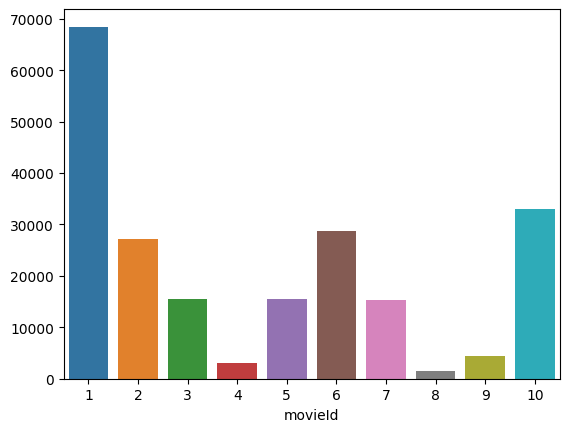

In [116]:
# Gör en plot över antalet ratings mot movieId

f = movies_num_ratings[:10]

sns.barplot(x=f.index, y=f)
f
